# WSI - ćwiczenie 4
## Regresja i klasyfikacja
## Yaroslav Harbar

Głównym celem tego ćwiczenia było zaimplementowanie algorytmu ID3 tworzącego drzewa decyzyjne z ograniczeniem maksymalnej głębokości. ID3 wykorzystuje zachłanne podejście odgórne do budowania drzewa, czyli podejście, które polega na tym, że w każdej iteracji algorytm wybiera najlepszą w danych momencie cechę do stworzenia węzła.
Potem wykorzystałem stworzony algorytm do stworzenia i zbadania klasyfikatorów dla zbioru danych *Cardio Vascular Disease Detection*, gdzie klasą jest pole *cardio*.

In [31]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

## Przygotowanie danych

Przed rozpoczęciem pracy z podanymi danymi, należało zdyskretyzować niektóre z atrybutów (wiek, wzrost, waga, ciśnienie skurczowe, ciśnienie rozkurczowe).

In [32]:
dataset = pd.read_csv("./cardio_train.csv", sep=';')
dataset.head()

dataset.drop(["id"], axis=1, inplace=True)
dataset["age"] = dataset["age"].apply(lambda x: x > 60 * 365)
dataset["height"] = dataset["height"].apply(lambda x: x > 170)
dataset["weight"] = dataset["weight"].apply(lambda x: x > 80)
dataset["ap_hi"] = dataset["ap_hi"].apply(lambda x: x > 140)
dataset["ap_lo"] = dataset["ap_lo"].apply(lambda x: x < 80)
dataset["cholesterol"] = dataset["cholesterol"].apply(lambda x: "normal" if x == 1 else "above normal" if x == 2 else "well above normal")
dataset["gluc"] = dataset["gluc"].apply(lambda x: "normal" if x == 1 else "above normal" if x == 2 else "well above normal")
dataset["smoke"] = dataset["smoke"].apply(lambda x: x == 1)
dataset["alco"] = dataset["alco"].apply(lambda x: x == 1)
dataset["active"] = dataset["active"].apply(lambda x: x == 1)
dataset["cardio"] = dataset["cardio"].apply(lambda x: x == 1)

In [33]:
dataset.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,True,1,False,False,False,False,above normal,above normal,False,False,True,False
1,False,1,False,False,False,True,normal,normal,False,False,True,True
2,True,1,False,False,False,False,normal,normal,False,False,True,False
3,False,2,False,True,False,False,normal,normal,True,True,True,False
4,True,1,False,False,False,False,normal,normal,False,False,True,False


## Implementacja algorytmu ID3

Następnie implementuję algorytm ID3 w celu tworzenia drzewa decyzyjnego. Do tego stworzyłem klasę *DecisionTreeId3*, która przy tworzeniu obiektu, przyjmuje dwie wartości: *class_label* (nazwa pola klasy) oraz depth (głębokość). W środku klasy *DecisionTreeId3* zaimplementowane jest kilka metod, które pomagają w tworzeniu drzewa i analizie danych. Metoda *get_ig* oblicza redukcję entropii i mierzy, jak dana cecha klasyfikuje klasy docelowe. Obliczam IG (Information Gain) dla każdej cechy. Następnie biorąc pod uwagę, że nie wszystkie wiersze należą do tej samej klasy, dzielę zbiór danych na podzbiory, korzystając z cechy, dla której IG jest maksymalny. Potem z tej cechy tworzony jest węzeł drzewa decyzyjnego. Jeżeli wszystkie wiersze należą do tej samej klasy, bieżący węzeł ustawiam jako węzeł liścia z klasą jako etykietą. Funkcjonalność ta zaimplementowana jest w metodzie *generate_tree*. Do walidacji i testowania danych korzystam z macierzy błędów, na podstawie której obliczam *F1-Score*. Zbiór danych dzielę na zbiór trenujący, walidacyjny i testowy za pomocą metody *train_test_split* z biblioteki sklearn.

In [34]:
class DecisionTreeId3:
    def __init__(self, class_label, depth):
        self.class_label = class_label
        self.depth = depth
        self.tree = {}
        self.f1_score = None
        self.confusion_matrix_data_frame = pd.DataFrame()

    def get_parameters(self):
        """Returns the hyperparameters"""
        return (
            self.class_label,
            self.depth,
            self.tree,
            self.f1_score,
            self.confusion_matrix_data_frame
        )

    def get_total_entropy(self, data, class_label):
        class_list, class_count = np.unique(data[class_label], return_counts=True)
        entropy = 0

        for i in range(len(class_list)):
            class_probability = class_count[i]/np.sum(class_count)
            class_entropy = (-class_probability)*np.log2(class_probability)
            entropy += class_entropy

        return entropy

    def get_feature_entropy(self, feature_data, class_label):
        class_list, class_count = np.unique(feature_data[class_label], return_counts=True)
        entropy = 0

        for i in range(len(class_list)):
            feature_class_count = feature_data[feature_data[class_label] == class_list[i]].shape[0]
            class_entropy = 0

            if feature_class_count != 0:
                class_probability = feature_class_count/np.sum(class_count)
                class_entropy = (-class_probability)*np.log2(class_probability)

            entropy += class_entropy

        return entropy

    def get_ig(self, data, feature_label, class_label):
        total_entropy = self.get_total_entropy(data, class_label)
        [feature_label_values, feature_label_count] = np.unique(data[feature_label], return_counts=True)
        ig = total_entropy

        for i in range(len(feature_label_values)):
            feature_value_data = data[data[feature_label] == feature_label_values[i]]
            feature_value_probability = feature_label_count[i]/np.sum(feature_label_count)
            ig -= self.get_feature_entropy(feature_value_data, class_label) * feature_value_probability

        return ig

    def find_the_best_feature(self, data, class_label):
        feature_column_list = data.columns.drop(class_label)
        max_ig = -1
        best_feature = None

        for feature in feature_column_list:
            ig = self.get_ig(data, feature, class_label)

            if ig > max_ig:
                best_feature = feature
                max_ig = ig

        return best_feature

    def generate_tree(self, data, class_label, depth):
        if data.shape[0] != 0:
            if depth == 0:
                return data[class_label].value_counts().idxmax()
            if len(np.unique(data[class_label])) == 1:
                return np.unique(data[class_label])[0]
            else:
                best_feature = self.find_the_best_feature(data, class_label)

                tree = {best_feature: {}}

                for feature_value in np.unique(data[best_feature]):
                    sub_data = data[data[best_feature] == feature_value]
                    sub_data.pop(best_feature)

                    subtree = self.generate_tree(sub_data, class_label, depth - 1)
                    tree[best_feature][feature_value] = subtree
                return tree
        return {}

    def fit(self, X, y):
        training_data = X
        training_data[self.class_label] = y
        training_data.dropna(inplace=True)

        self.tree = self.generate_tree(training_data, self.class_label, self.depth)

    def get_instance_predict(self, tree, instance):
        if not isinstance(tree, dict):
            return tree
        else:
            root = next(iter(tree))
            feature_value = instance[root]
            if feature_value in tree[root]:
                return self.get_instance_predict(tree[root][feature_value], instance)
            else:
                return False

    def predict(self, X):
        return [self.get_instance_predict(self.tree, X.iloc[i]) for i in range(X.shape[0])]

    def draw_confusion_matrix(self):
        if not self.confusion_matrix_data_frame.empty:
            plt.figure()
            heatmap = sns.heatmap(self.confusion_matrix_data_frame, annot=True, cmap="Blues", fmt='g')
            heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
            heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')

            plt.ylabel('Actual label')
            plt.xlabel('Predicted label')
            plt.title('Confusion Matrix')

            plt.show()

    def print_evaluate_info(self):
        print("Depth: ", self.depth)
        print("F1 score: ", self.f1_score)

    def get_metrics(self, y_test, y_predict):
        confusion_matrix = np.mat(metrics.confusion_matrix(y_test, y_predict))
        class_names = list(set(y_train))

        confusion_matrix_data_frame = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)

        TN = confusion_matrix[0, 0]
        FP = confusion_matrix[0, 1]
        FN = confusion_matrix[1, 0]
        TP = confusion_matrix[1, 1]

        precision = TP / (TP + FP)
        sensitivity = TP / (TP + FN)

        f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)

        self.confusion_matrix_data_frame = confusion_matrix_data_frame
        self.f1_score = f1_score

        return f1_score


    def evaluate(self, X, y):
        dataset = X
        dataset[self.class_label] = y

        dataset.dropna(inplace=True)

        y_test = dataset[self.class_label]
        y_predict = self.predict(dataset.drop([class_label], axis=1))

        f1_score = self.get_metrics(y_test, y_predict)

        return f1_score

In [35]:
def split_data(dataset, train_size, test_size):
    dataset.dropna(inplace=True)

    clean_y = dataset[class_label]
    clean_X = dataset.drop([class_label], axis=1)

    X_train, X_rem, y_train, y_rem = train_test_split(clean_X, clean_y, train_size=train_size)
    X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=test_size)

    return (
        (X_train, y_train),
        (X_valid, y_valid),
        (X_test, y_test)
    )

Dodatkowo stworzyłem metodę *find_the_best_model*, która na postawie podzielonego zestawu danych szuka głębokości, która daje najlepszy wynik walidujący.

In [36]:
def find_the_best_model(class_label, X_train, y_train, X_valid, y_valid, X_test, y_test):
    best_model = None
    best_score = 0
    depths = []
    validation_scores = []
    train_scores = []

    for i in range(1, 11):
        d = DecisionTreeId3(class_label, i)
        d.fit(X_train, y_train)
        validation_score = d.evaluate(X_valid, y_valid)
        train_score = d.evaluate(X_train, y_train)

        d.draw_confusion_matrix()
        d.print_evaluate_info()

        print("-"*100)

        if validation_score > best_score:
            best_score = validation_score
            best_model = d

        depths.append(i)
        validation_scores.append(validation_score)
        train_scores.append(train_score)

    plt.plot(depths, validation_scores, label="validation data")
    plt.plot(depths, train_scores, label="training data")
    plt.legend(loc="lower right")
    plt.show()

    print("-"*100)
    print("Best model depth: ", best_model.depth)
    print("Score: ", best_model.evaluate(X_test, y_test))

## Testowanie algorytmu

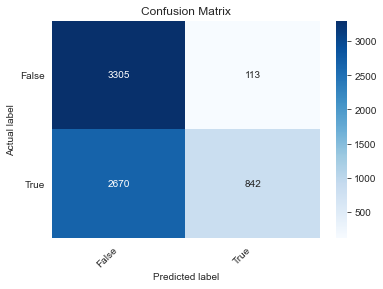

Depth:  1
F1 score:  0.3769867920304455
----------------------------------------------------------------------------------------------------


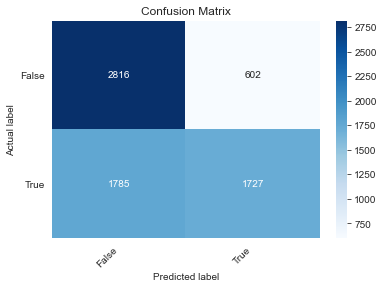

Depth:  2
F1 score:  0.5913370998116761
----------------------------------------------------------------------------------------------------


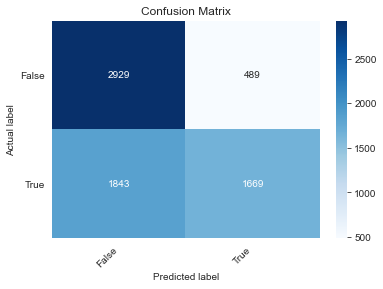

Depth:  3
F1 score:  0.5887125220458553
----------------------------------------------------------------------------------------------------


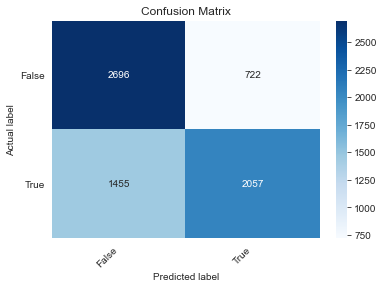

Depth:  4
F1 score:  0.6539500874264822
----------------------------------------------------------------------------------------------------


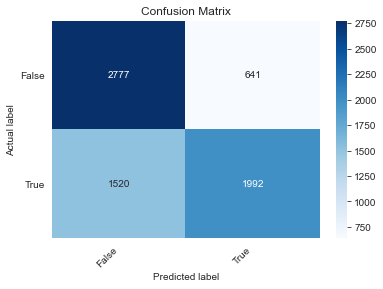

Depth:  5
F1 score:  0.6483319772172498
----------------------------------------------------------------------------------------------------


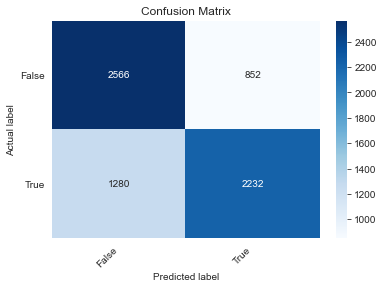

Depth:  6
F1 score:  0.6767738023044269
----------------------------------------------------------------------------------------------------


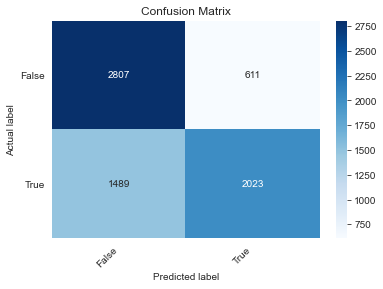

Depth:  7
F1 score:  0.6583143507972665
----------------------------------------------------------------------------------------------------


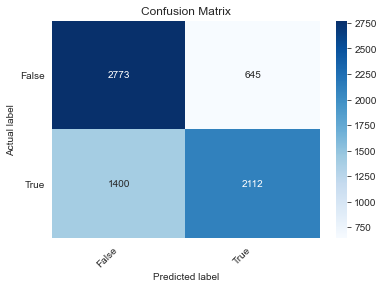

Depth:  8
F1 score:  0.6737916733131281
----------------------------------------------------------------------------------------------------


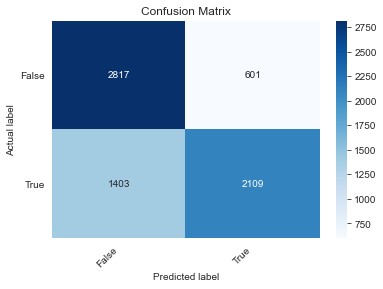

Depth:  9
F1 score:  0.677917068466731
----------------------------------------------------------------------------------------------------


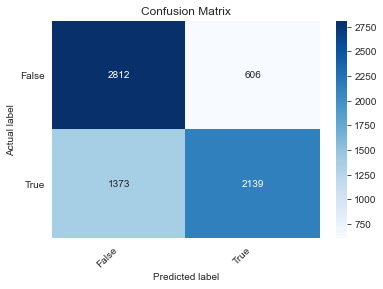

Depth:  10
F1 score:  0.6837142400511427
----------------------------------------------------------------------------------------------------


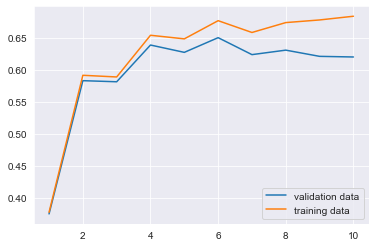

----------------------------------------------------------------------------------------------------
Best model depth:  6
Score:  0.6485987064983061


In [37]:
class_label = "cardio"

((X_train, y_train), (X_valid, y_valid), (X_test, y_test)) = split_data(dataset, 0.1, 0.5)
find_the_best_model(class_label, X_train, y_train, X_valid, y_valid, X_test, y_test)

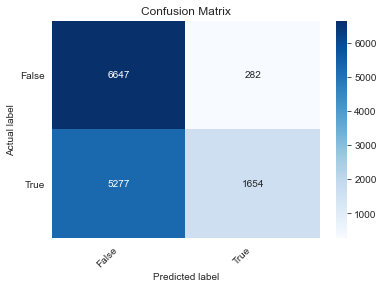

Depth:  1
F1 score:  0.37306868162851026
----------------------------------------------------------------------------------------------------


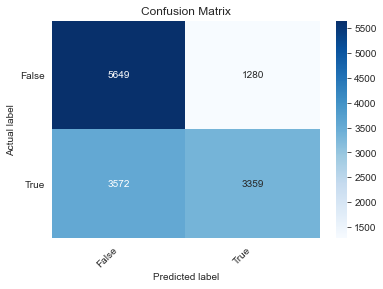

Depth:  2
F1 score:  0.5806395851339671
----------------------------------------------------------------------------------------------------


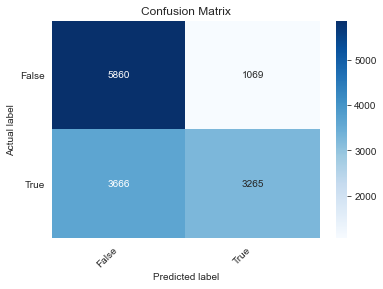

Depth:  3
F1 score:  0.5796715490457168
----------------------------------------------------------------------------------------------------


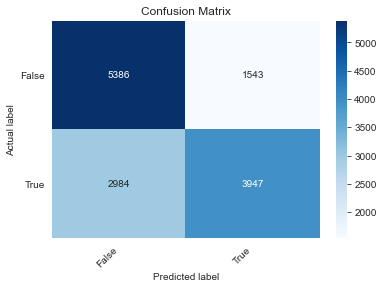

Depth:  4
F1 score:  0.6355365912567427
----------------------------------------------------------------------------------------------------


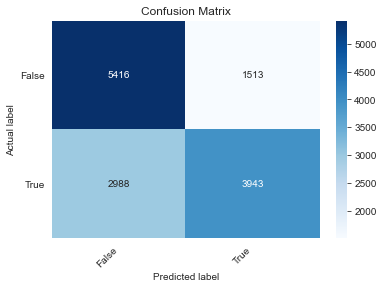

Depth:  5
F1 score:  0.636635182045693
----------------------------------------------------------------------------------------------------


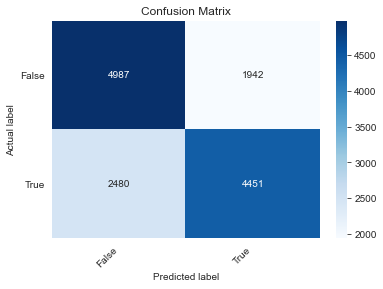

Depth:  6
F1 score:  0.6681176823776643
----------------------------------------------------------------------------------------------------


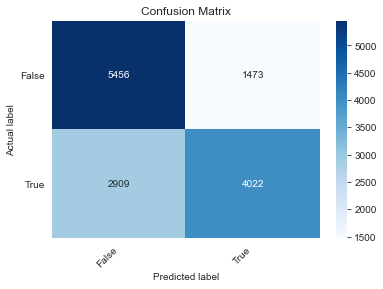

Depth:  7
F1 score:  0.6473523257685498
----------------------------------------------------------------------------------------------------


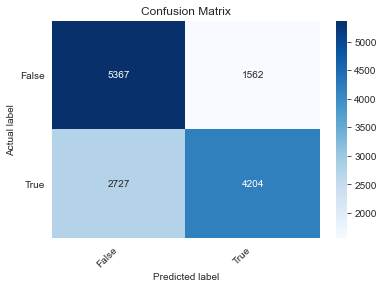

Depth:  8
F1 score:  0.6622036701583052
----------------------------------------------------------------------------------------------------


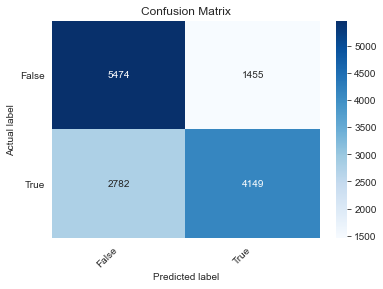

Depth:  9
F1 score:  0.6619864379736737
----------------------------------------------------------------------------------------------------


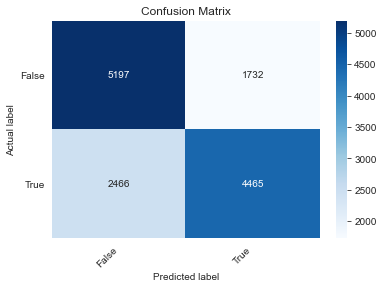

Depth:  10
F1 score:  0.6802254722730042
----------------------------------------------------------------------------------------------------


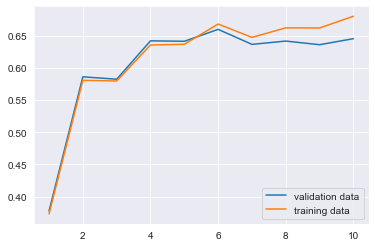

----------------------------------------------------------------------------------------------------
Best model depth:  6
Score:  0.6534368490816134


In [38]:
class_label = "cardio"

((X_train, y_train), (X_valid, y_valid), (X_test, y_test)) = split_data(dataset, 0.2, 0.5)
find_the_best_model(class_label, X_train, y_train, X_valid, y_valid, X_test, y_test)

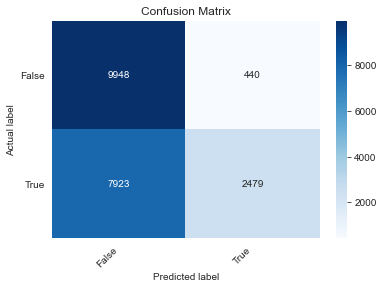

Depth:  1
F1 score:  0.3721942797087306
----------------------------------------------------------------------------------------------------


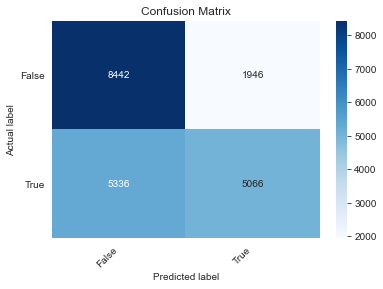

Depth:  2
F1 score:  0.5818307109222465
----------------------------------------------------------------------------------------------------


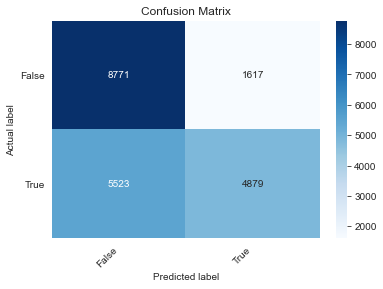

Depth:  3
F1 score:  0.5774647887323943
----------------------------------------------------------------------------------------------------


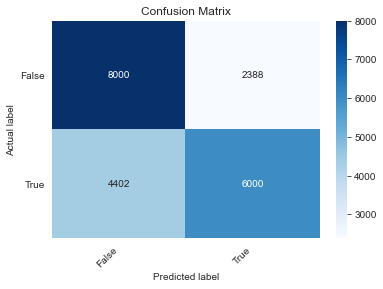

Depth:  4
F1 score:  0.6386375731772219
----------------------------------------------------------------------------------------------------


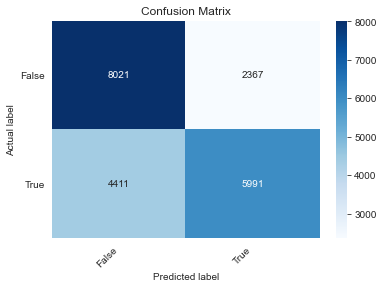

Depth:  5
F1 score:  0.6386993603411514
----------------------------------------------------------------------------------------------------


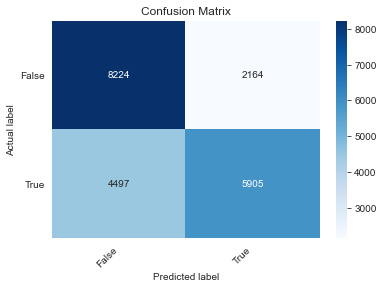

Depth:  6
F1 score:  0.639380650749824
----------------------------------------------------------------------------------------------------


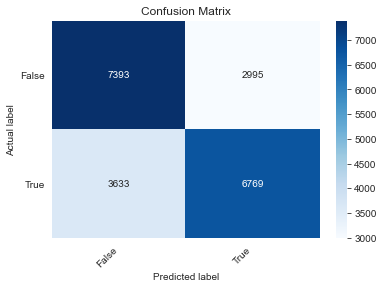

Depth:  7
F1 score:  0.6713279777843896
----------------------------------------------------------------------------------------------------


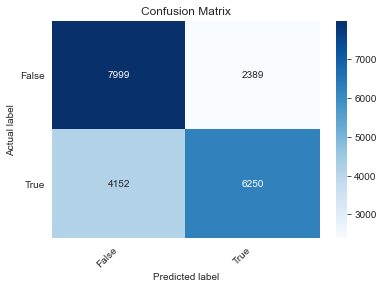

Depth:  8
F1 score:  0.6564781261488368
----------------------------------------------------------------------------------------------------


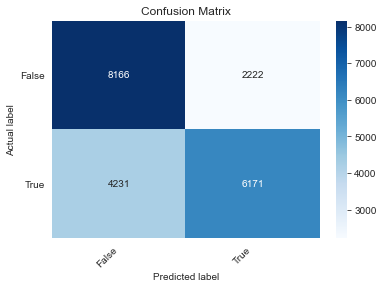

Depth:  9
F1 score:  0.6566640063846767
----------------------------------------------------------------------------------------------------


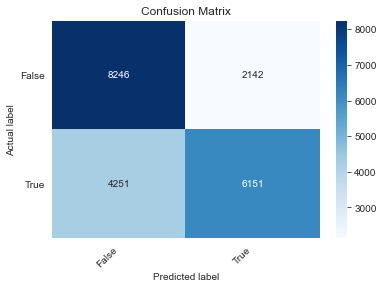

Depth:  10
F1 score:  0.6580369082642418
----------------------------------------------------------------------------------------------------


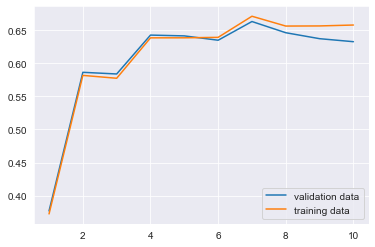

----------------------------------------------------------------------------------------------------
Best model depth:  7
Score:  0.6592804893698935


In [39]:
class_label = "cardio"

((X_train, y_train), (X_valid, y_valid), (X_test, y_test)) = split_data(dataset, 0.3, 0.5)
find_the_best_model(class_label, X_train, y_train, X_valid, y_valid, X_test, y_test)

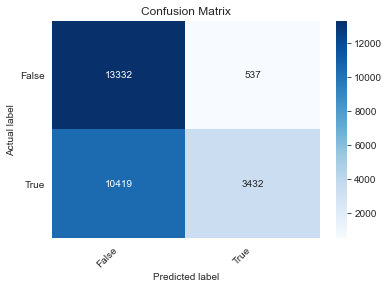

Depth:  1
F1 score:  0.3851851851851852
----------------------------------------------------------------------------------------------------


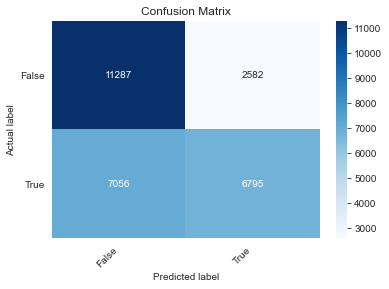

Depth:  2
F1 score:  0.5850697434131221
----------------------------------------------------------------------------------------------------


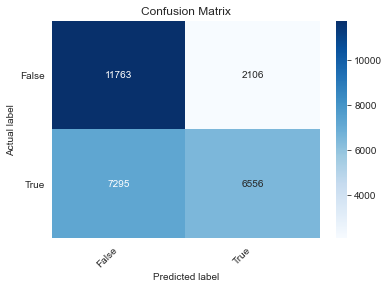

Depth:  3
F1 score:  0.5824190467729756
----------------------------------------------------------------------------------------------------


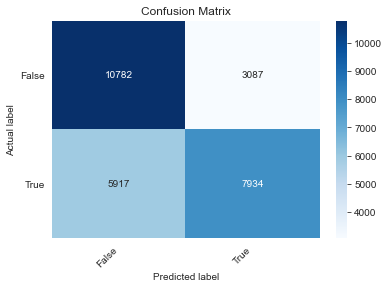

Depth:  4
F1 score:  0.6379864908330652
----------------------------------------------------------------------------------------------------


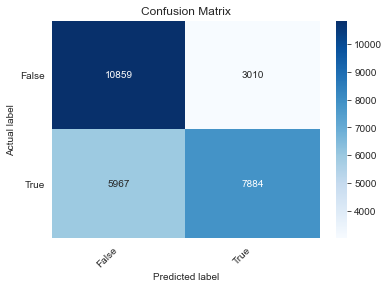

Depth:  5
F1 score:  0.63721964033138
----------------------------------------------------------------------------------------------------


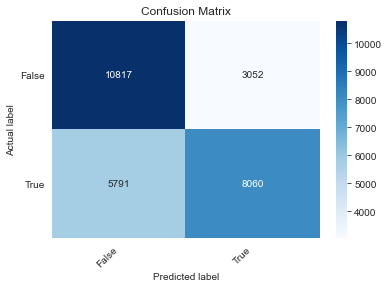

Depth:  6
F1 score:  0.6457557184633258
----------------------------------------------------------------------------------------------------


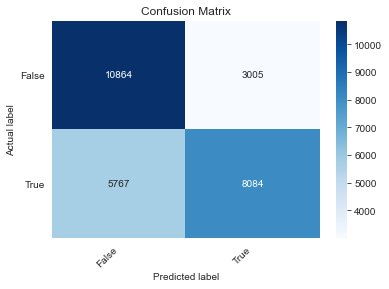

Depth:  7
F1 score:  0.6482758620689655
----------------------------------------------------------------------------------------------------


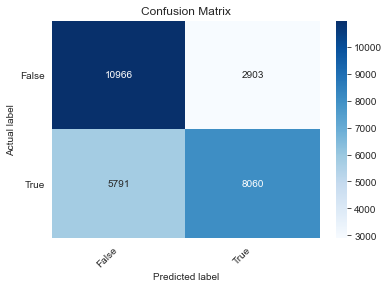

Depth:  8
F1 score:  0.6496332715402595
----------------------------------------------------------------------------------------------------


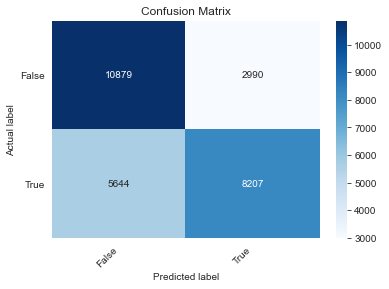

Depth:  9
F1 score:  0.6553018205046311
----------------------------------------------------------------------------------------------------


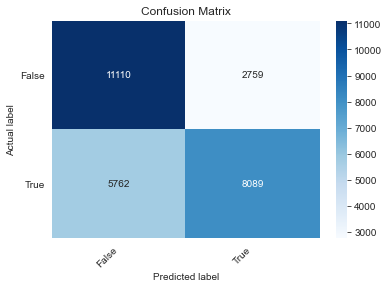

Depth:  10
F1 score:  0.6550062755577148
----------------------------------------------------------------------------------------------------


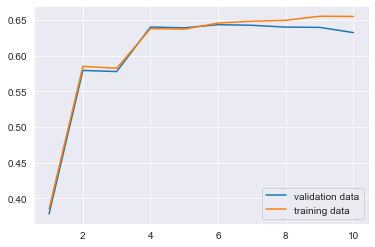

----------------------------------------------------------------------------------------------------
Best model depth:  6
Score:  0.6405424163151994


In [40]:
class_label = "cardio"

((X_train, y_train), (X_valid, y_valid), (X_test, y_test)) = split_data(dataset, 0.4, 0.5)
find_the_best_model(class_label, X_train, y_train, X_valid, y_valid, X_test, y_test)

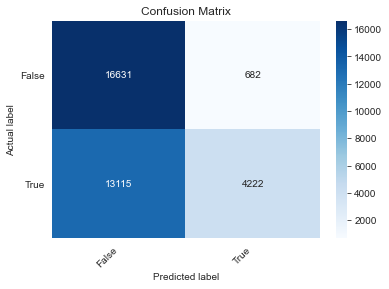

Depth:  1
F1 score:  0.37965918798615167
----------------------------------------------------------------------------------------------------


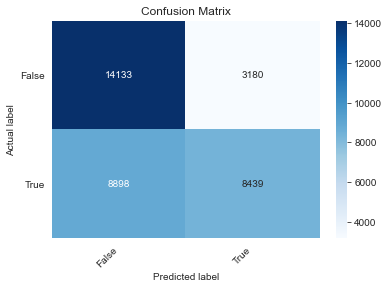

Depth:  2
F1 score:  0.5828843762950684
----------------------------------------------------------------------------------------------------


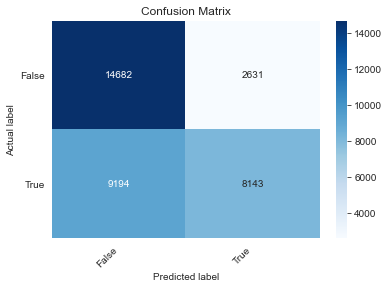

Depth:  3
F1 score:  0.5793461634235709
----------------------------------------------------------------------------------------------------


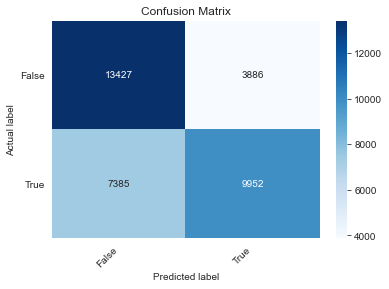

Depth:  4
F1 score:  0.6384603047313552
----------------------------------------------------------------------------------------------------


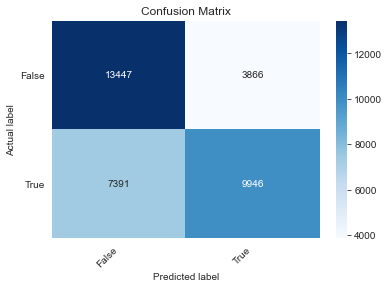

Depth:  5
F1 score:  0.6386079809945744
----------------------------------------------------------------------------------------------------


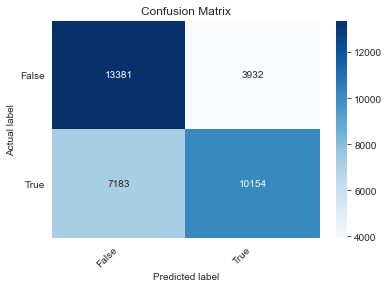

Depth:  6
F1 score:  0.6462782038634122
----------------------------------------------------------------------------------------------------


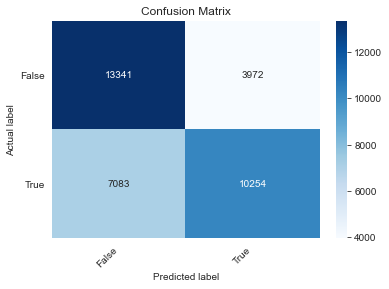

Depth:  7
F1 score:  0.6497481228020151
----------------------------------------------------------------------------------------------------


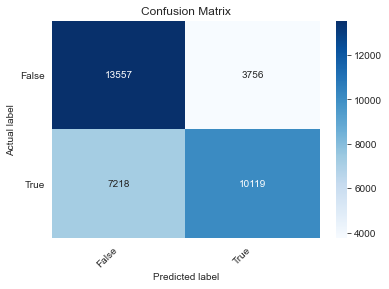

Depth:  8
F1 score:  0.6484044598231449
----------------------------------------------------------------------------------------------------


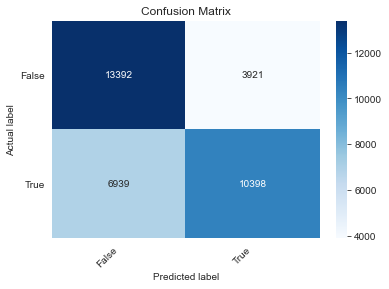

Depth:  9
F1 score:  0.6569370735405611
----------------------------------------------------------------------------------------------------


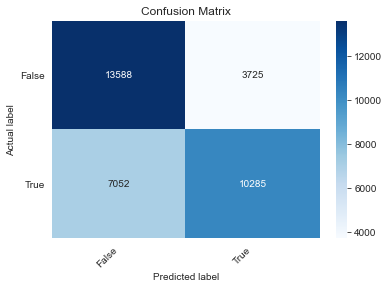

Depth:  10
F1 score:  0.6562031454365649
----------------------------------------------------------------------------------------------------


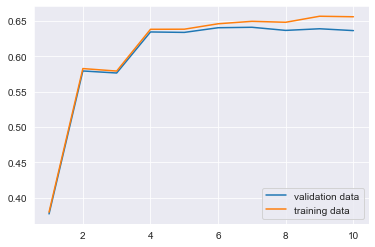

----------------------------------------------------------------------------------------------------
Best model depth:  7
Score:  0.6496919401483717


In [41]:
class_label = "cardio"

((X_train, y_train), (X_valid, y_valid), (X_test, y_test)) = split_data(dataset, 0.5, 0.5)
find_the_best_model(class_label, X_train, y_train, X_valid, y_valid, X_test, y_test)

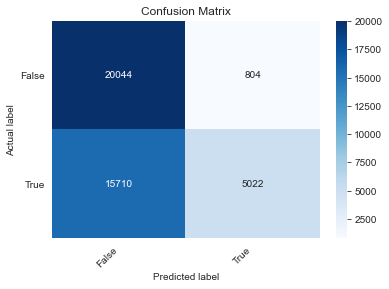

Depth:  1
F1 score:  0.37819112885006406
----------------------------------------------------------------------------------------------------


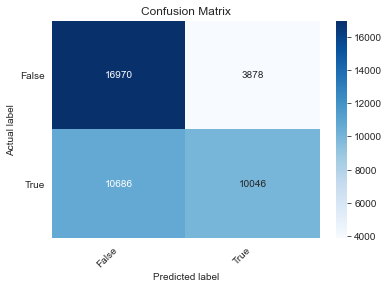

Depth:  2
F1 score:  0.5797553093259464
----------------------------------------------------------------------------------------------------


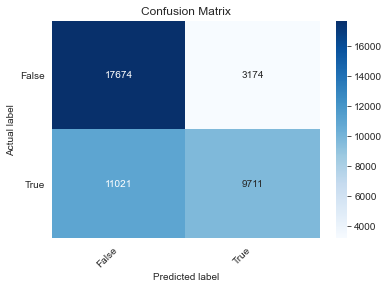

Depth:  3
F1 score:  0.5777434036350656
----------------------------------------------------------------------------------------------------


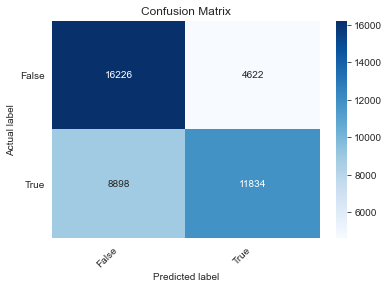

Depth:  4
F1 score:  0.6364418629665484
----------------------------------------------------------------------------------------------------


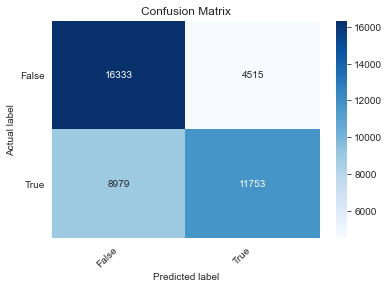

Depth:  5
F1 score:  0.6352972972972973
----------------------------------------------------------------------------------------------------


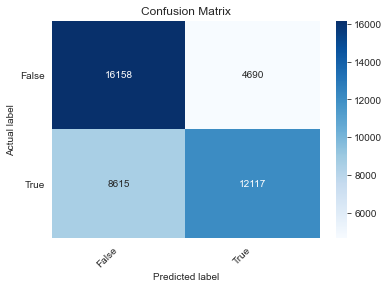

Depth:  6
F1 score:  0.6455686086470072
----------------------------------------------------------------------------------------------------


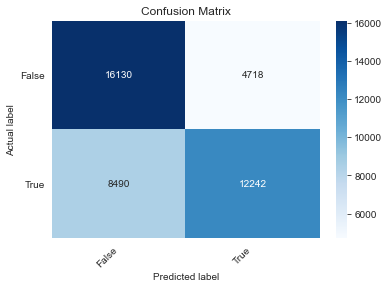

Depth:  7
F1 score:  0.6495808129045951
----------------------------------------------------------------------------------------------------


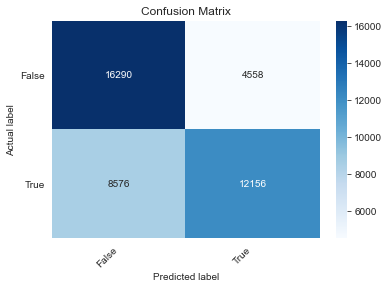

Depth:  8
F1 score:  0.6492549270950169
----------------------------------------------------------------------------------------------------


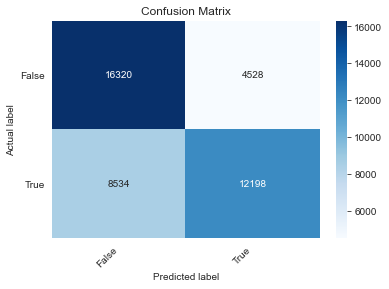

Depth:  9
F1 score:  0.6512894441774788
----------------------------------------------------------------------------------------------------


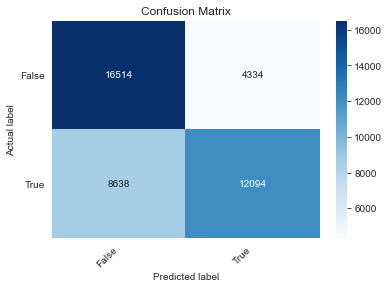

Depth:  10
F1 score:  0.6509149623250807
----------------------------------------------------------------------------------------------------


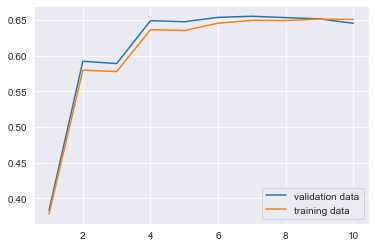

----------------------------------------------------------------------------------------------------
Best model depth:  7
Score:  0.6384401114206127


In [42]:
class_label = "cardio"

((X_train, y_train), (X_valid, y_valid), (X_test, y_test)) = split_data(dataset, 0.6, 0.5)
find_the_best_model(class_label, X_train, y_train, X_valid, y_valid, X_test, y_test)

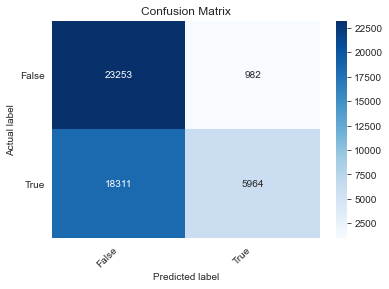

Depth:  1
F1 score:  0.38205054290381474
----------------------------------------------------------------------------------------------------


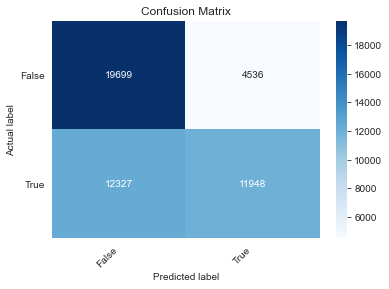

Depth:  2
F1 score:  0.5862754238327732
----------------------------------------------------------------------------------------------------


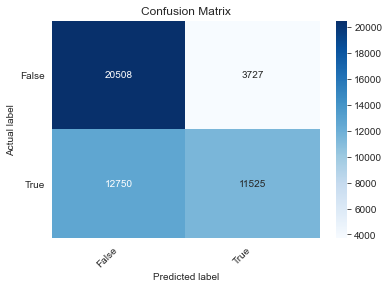

Depth:  3
F1 score:  0.5831456978774002
----------------------------------------------------------------------------------------------------


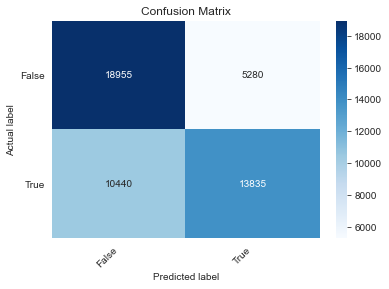

Depth:  4
F1 score:  0.6377045402166398
----------------------------------------------------------------------------------------------------


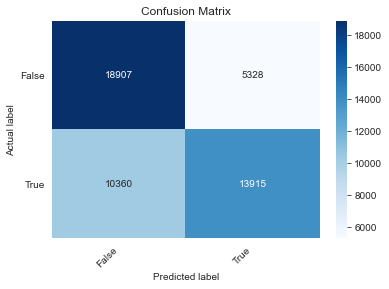

Depth:  5
F1 score:  0.63950549198033
----------------------------------------------------------------------------------------------------


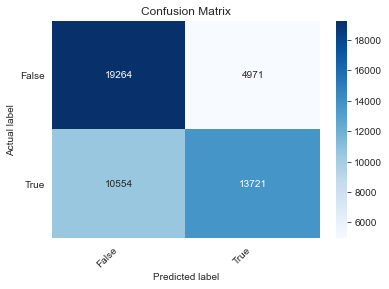

Depth:  6
F1 score:  0.6386761933576931
----------------------------------------------------------------------------------------------------


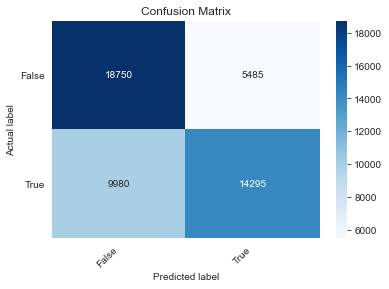

Depth:  7
F1 score:  0.6489615253660198
----------------------------------------------------------------------------------------------------


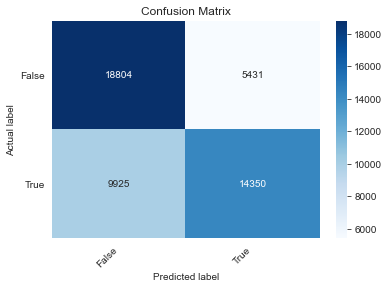

Depth:  8
F1 score:  0.6514436172144543
----------------------------------------------------------------------------------------------------


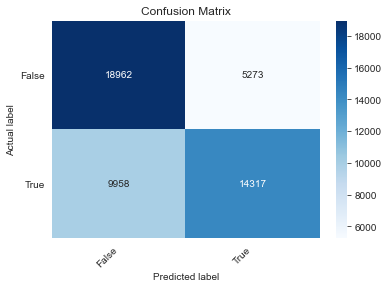

Depth:  9
F1 score:  0.6527755613815114
----------------------------------------------------------------------------------------------------


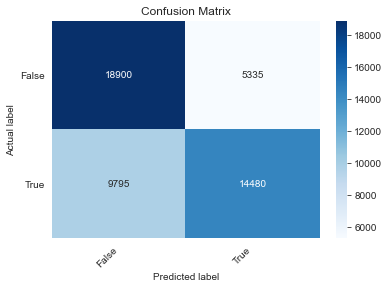

Depth:  10
F1 score:  0.6568382853254706
----------------------------------------------------------------------------------------------------


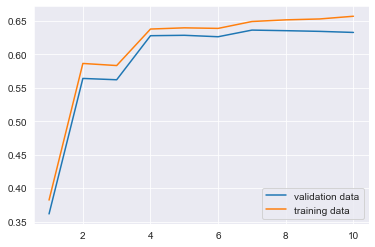

----------------------------------------------------------------------------------------------------
Best model depth:  7
Score:  0.6433311924641404


In [43]:
class_label = "cardio"

((X_train, y_train), (X_valid, y_valid), (X_test, y_test)) = split_data(dataset, 0.7, 0.5)
find_the_best_model(class_label, X_train, y_train, X_valid, y_valid, X_test, y_test)

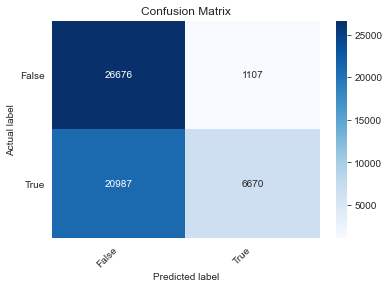

Depth:  1
F1 score:  0.37647457244454485
----------------------------------------------------------------------------------------------------


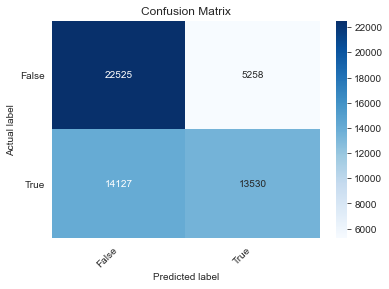

Depth:  2
F1 score:  0.5826246097534719
----------------------------------------------------------------------------------------------------


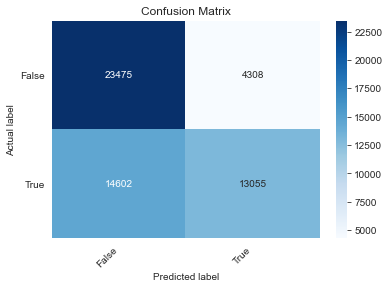

Depth:  3
F1 score:  0.5799644602398933
----------------------------------------------------------------------------------------------------


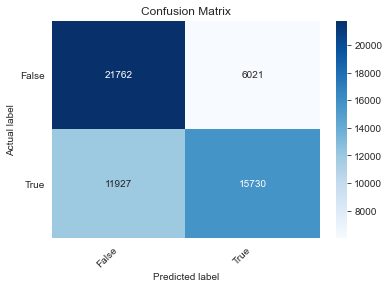

Depth:  4
F1 score:  0.6367389896373057
----------------------------------------------------------------------------------------------------


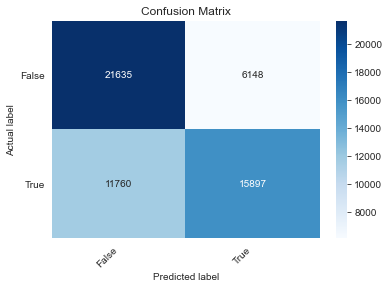

Depth:  5
F1 score:  0.6396925677035129
----------------------------------------------------------------------------------------------------


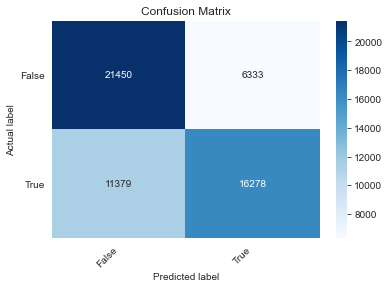

Depth:  6
F1 score:  0.6476486034853187
----------------------------------------------------------------------------------------------------


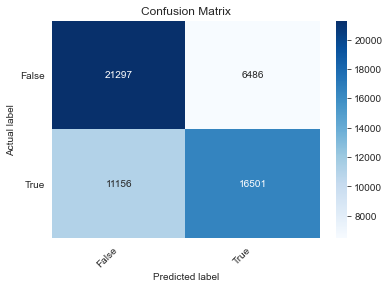

Depth:  7
F1 score:  0.6516467893531317
----------------------------------------------------------------------------------------------------


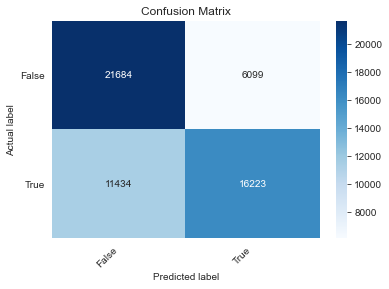

Depth:  8
F1 score:  0.6491926609175853
----------------------------------------------------------------------------------------------------


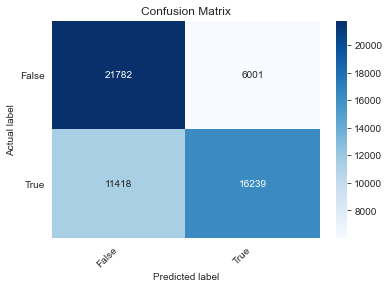

Depth:  9
F1 score:  0.6509008557628716
----------------------------------------------------------------------------------------------------


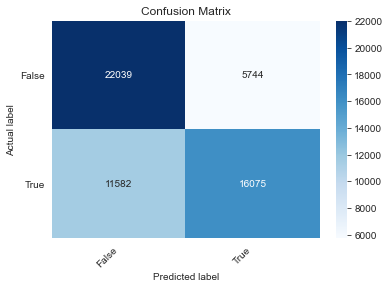

Depth:  10
F1 score:  0.6498100088932007
----------------------------------------------------------------------------------------------------


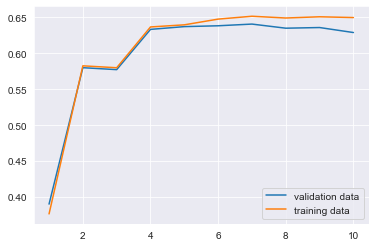

----------------------------------------------------------------------------------------------------
Best model depth:  7
Score:  0.6472898664571878


In [44]:
class_label = "cardio"

((X_train, y_train), (X_valid, y_valid), (X_test, y_test)) = split_data(dataset, 0.8, 0.5)
find_the_best_model(class_label, X_train, y_train, X_valid, y_valid, X_test, y_test)

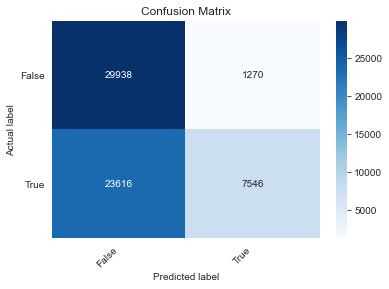

Depth:  1
F1 score:  0.37750762919605785
----------------------------------------------------------------------------------------------------


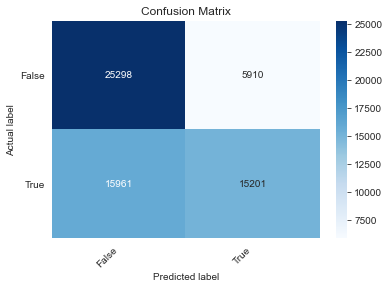

Depth:  2
F1 score:  0.5816004438237714
----------------------------------------------------------------------------------------------------


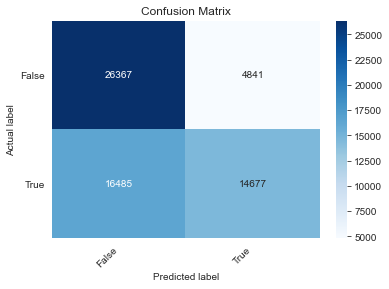

Depth:  3
F1 score:  0.5792028413575375
----------------------------------------------------------------------------------------------------


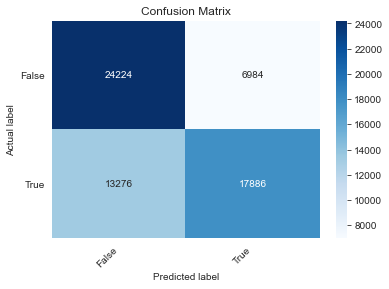

Depth:  4
F1 score:  0.6384209023415192
----------------------------------------------------------------------------------------------------


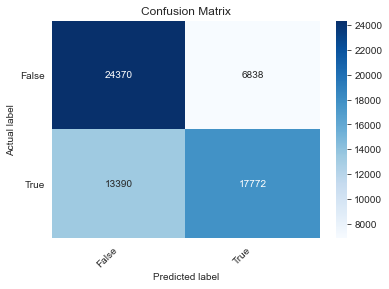

Depth:  5
F1 score:  0.6373090439647136
----------------------------------------------------------------------------------------------------


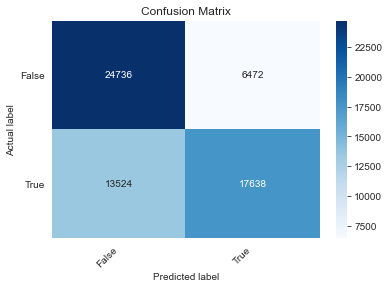

Depth:  6
F1 score:  0.6382255029671442
----------------------------------------------------------------------------------------------------


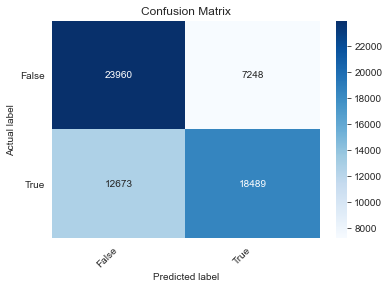

Depth:  7
F1 score:  0.6498883987416298
----------------------------------------------------------------------------------------------------


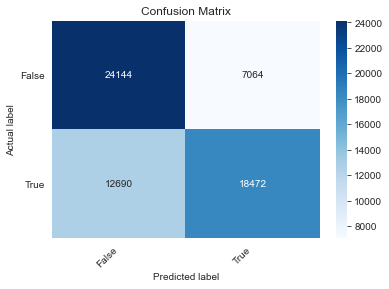

Depth:  8
F1 score:  0.6515926487706797
----------------------------------------------------------------------------------------------------


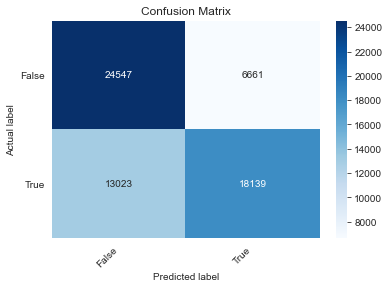

Depth:  9
F1 score:  0.6482613201815518
----------------------------------------------------------------------------------------------------


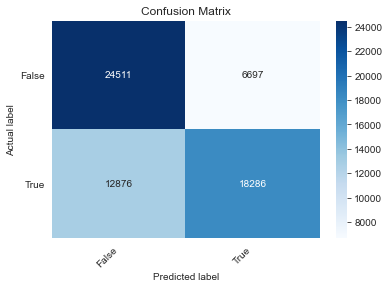

Depth:  10
F1 score:  0.6513848071956541
----------------------------------------------------------------------------------------------------


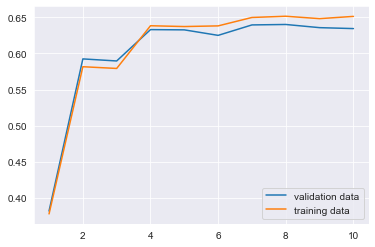

----------------------------------------------------------------------------------------------------
Best model depth:  8
Score:  0.6458797327394209


In [48]:
class_label = "cardio"

((X_train, y_train), (X_valid, y_valid), (X_test, y_test)) = split_data(dataset, 0.9, 0.5)
find_the_best_model(class_label, X_train, y_train, X_valid, y_valid, X_test, y_test)

# Wnioski
Analizując otrzymane wyniki, można wywnioskować, że najlepsze rezultaty otrzymujemy, gdy głębokość jest 6 lub 7, rzadziej 8 w zależności od podziału danych. Analizując wykres zależności głębokości od wyniku walidacji na przykład dla podziału 80%-10%-10%, można zaobserwować szybkie ulepszenie wyniku przy zwiększeniu głębokości od 1 do 6, co wskazuje o niedopasowaniu. Natomiast, zaczynając od głębokości równej 7, można zobaczyć powolny pogarszanie się wyniku dla zbioru walidacyjnego, co wskazuje, że od głębokości 7 występuje przetrenowanie. Podobnie jest dla pozostałych podziałów danych.

| Zbiór trenujący | Zbiór walidacyjny | Zbiór testowy | Najlepsza głębokość | Rezultat testowania |
|-----------------|-------------------|---------------|---------------------|---------------------|
| 10%             | 45%               | 45%           | 6                   | 0.6486              |
| 20%             | 40%               | 40%           | 6                   | 0.6534              |
| 30%             | 35%               | 35%           | 7                   | 0.6593              |
| 40%             | 30%               | 30%           | 6                   | 0.6405              |
| 50%             | 25%               | 25%           | 7                   | 0.6497              |
| 60%             | 20%               | 20%           | 7                   | 0.6384              |
| 70%             | 15%               | 15%           | 7                   | 0.6433              |
| 80%             | 10%               | 10%           | 7                   | 0.6473              |
| 90%             | 5%                | 5%            | 8                   | 0.6459              |